<h3>Packages and Versions</h3>

In [ ]:
#python version 3.12.2
#openai version 0.12.0
#pdfplumber version 0.10.3
#python-dotenv version 1.0.1

<h3>Prepare Imports</h3>

In [2]:
import openai
import base64
import datetime
import json
import os
import requests
import shutil
import time

from PIL import Image as PILimage
import pdfplumber

from dotenv import load_dotenv

<h3>Set the local directory to save the extracted images from the PDF containing the ERD (Entity Relationship Diagram).</h3>

In [3]:
images_dir = "LOCAL_FILE_PATH_TO_SAVE_IMAGES" # e.g. "c://extracted_images//"

if os.path.exists(images_dir):
    shutil.rmtree(images_dir)

os.makedirs(images_dir, exist_ok=True)

<h3>Read the PDF file and save extracted images to target directory</h3>
The PDF file was downloaded from SQLite Tutorial (https://www.sqlitetutorial.net/sqlite-sample-database/)
A copy of the PDF is also saved in this repository [sqlite-sample-database-diagram-color-original.pdf].

Note: Some ERDs are too large to fit on one page. This does not support ERD in multiple pages. This may be a future enhancement.

In [4]:
pdf_url = "LOCAL_FILE_PATH_OF_DOWNLOADED_SCHEMA_PDF" # e.g. "c://sqlite-sample-database.pdf Alternatively, you may also save the image file directly to images_dir

pdf = pdfplumber.open(pdf_url)
extracted_image = pdf.pages[0].to_image(resolution=600)
image_url = images_dir + "erd.png"
extracted_image.save(image_url, "PNG")

<h3>Convert local image URL to Base 64 Encoded data URL</h3>

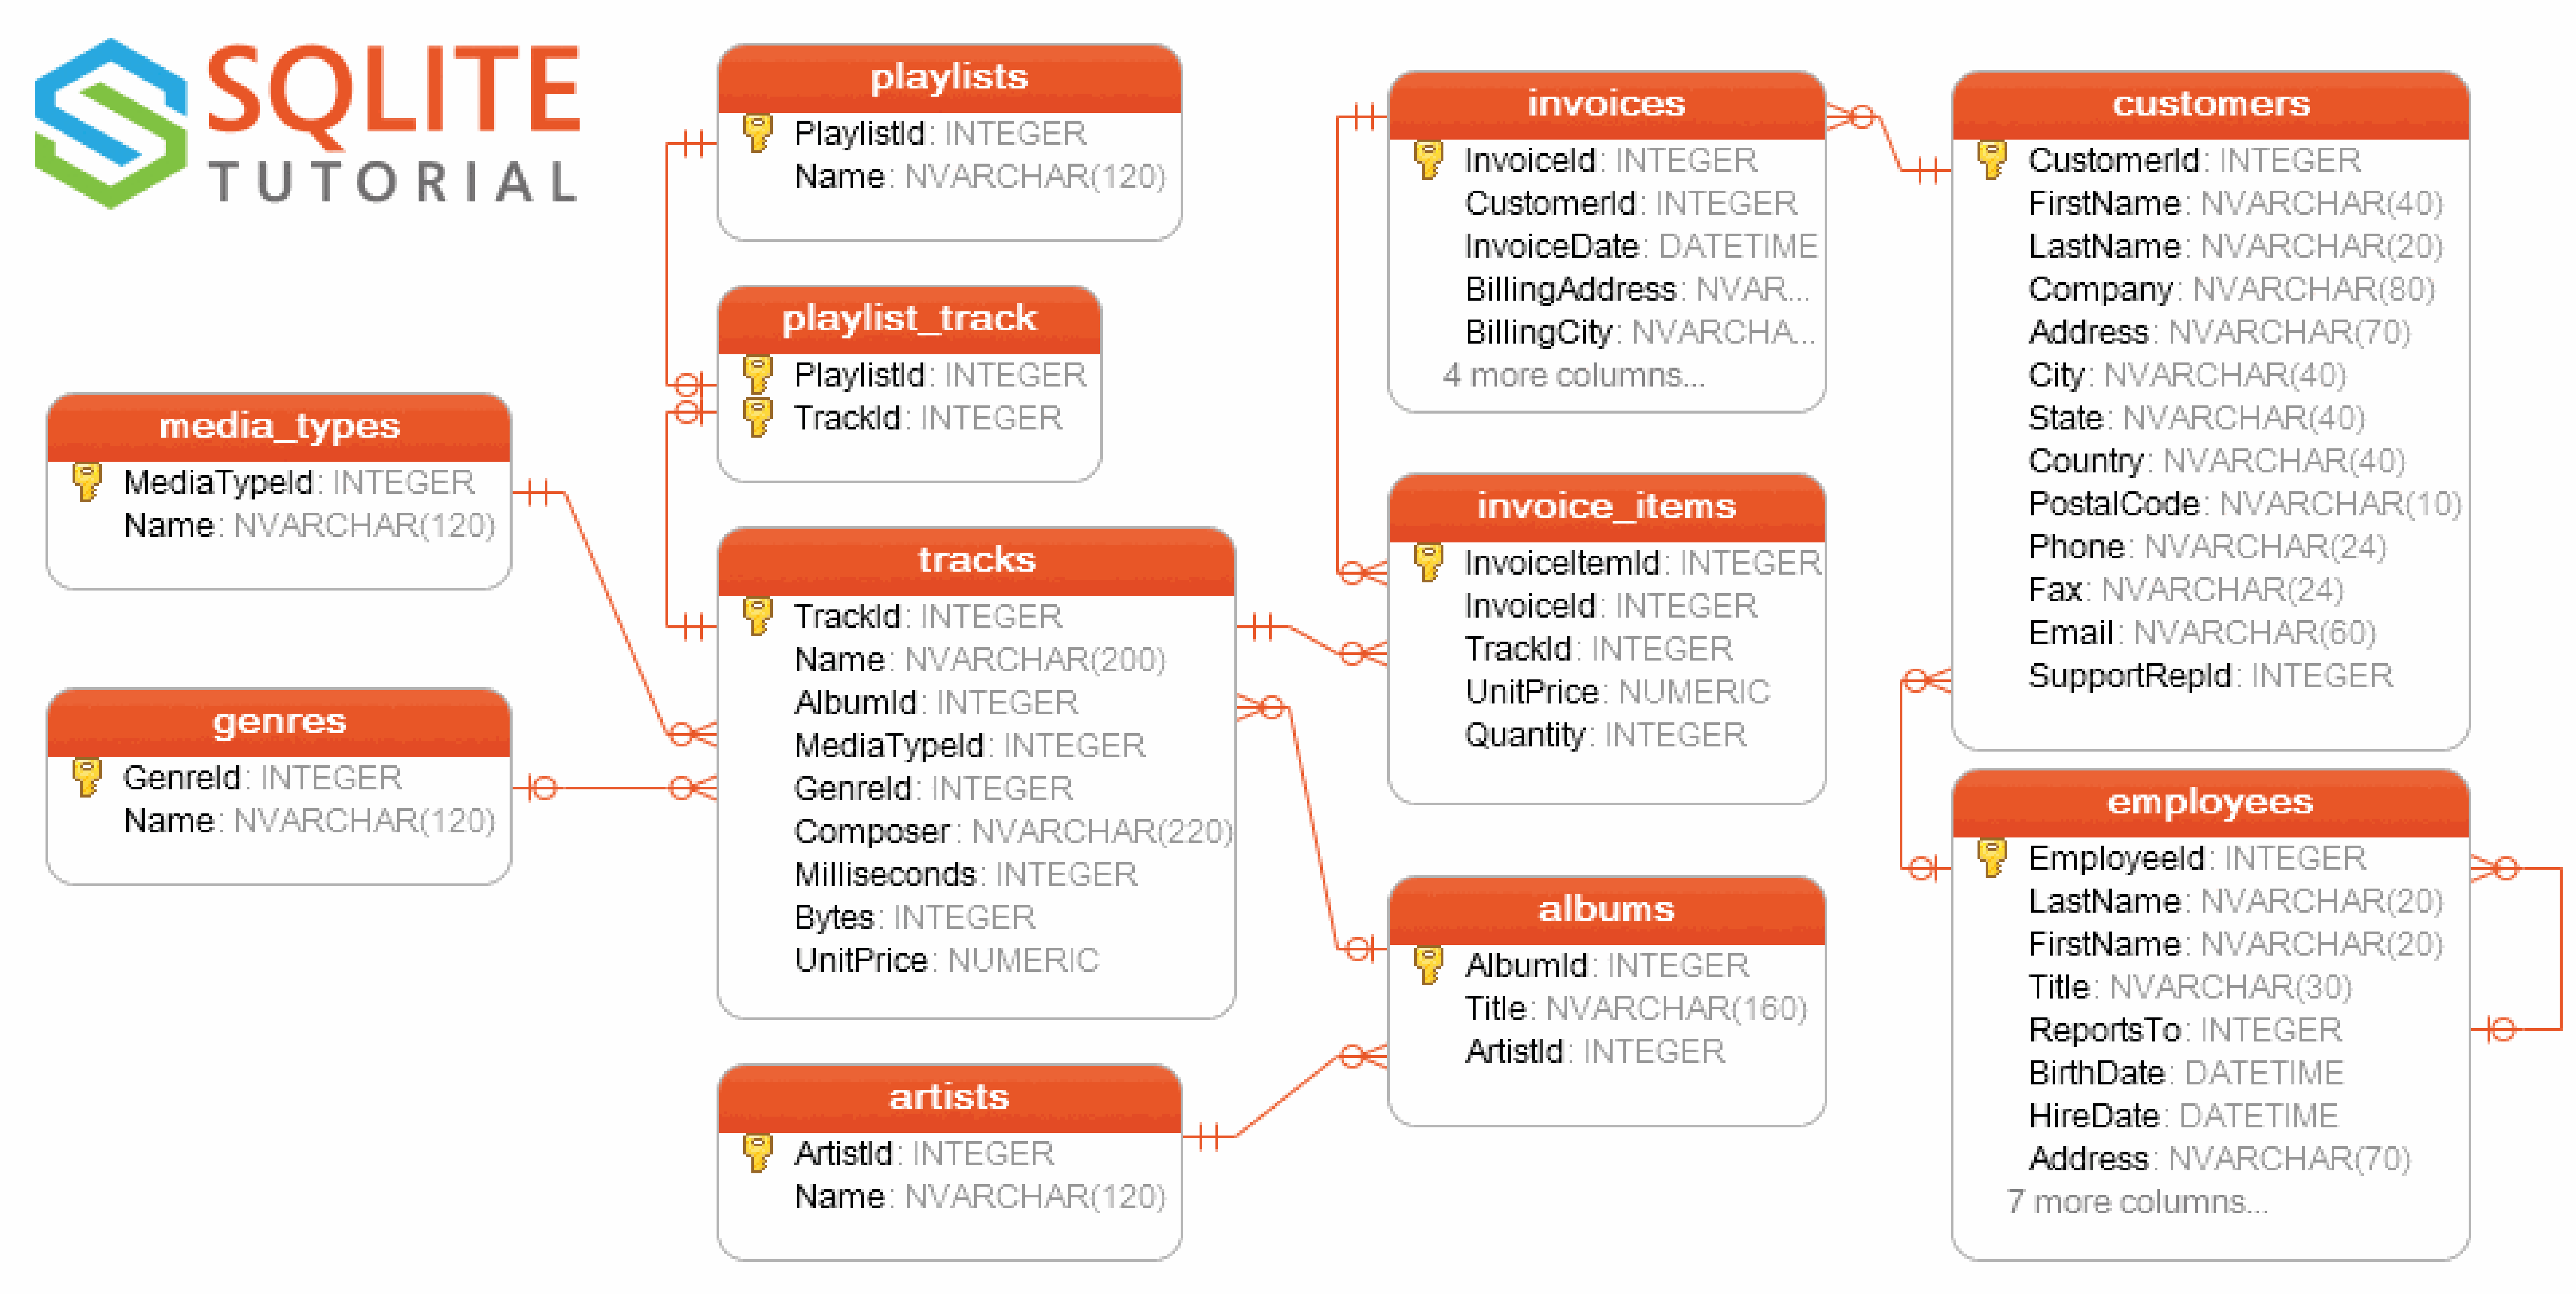

In [5]:
import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
image_path = image_url
base_64_encoded_data_url = local_image_to_data_url(image_path)

# View the ERD
display(PILimage.open(image_url))

<h3>Use GPT4V with Azure AI Vision enhancement</h3>
The environment variables are saved in the .env. Please assign the variables the appropriate endpoint and key values of your Azure resources.

In [6]:
load_dotenv()

#Azure OpenAI GPT4V
api_base = os.environ.get("AZURE_OPENAI_GPT4V_ENDPOINT")
API_KEY = os.environ.get("AZURE_OPENAI_GPT4V_API_KEY")
api_version = '2023-07-01-preview'
deployment_name = 'YOUR_GPT4V_DEPLOYMENT_NAME' #This example uses GPT-4V(ision) to extract the information from an ERD image. This is optional if you already have a database schema.

#Azure AI Vision
azure_aivision_endpoint = os.environ.get("AZURE_AI_VISION_ENDPOINT")
azure_aivision_key = os.environ.get("AZURE_AI_VISION_SUBSCRIPTION_KEY")


<h3>Prepare the System Prompt</h3>

In [7]:
system_message = """
                You are an AI assistant that helps Data Engineers with information regarding their database.
                Answer user questions by generating SQL queries based on provided database schema.
                """

<h3>Function to Extract Information from an Image using GPT4V</h3>

In [8]:
def GPT4V_with_AzureAIVision(base_64_encoded_data_url, prompt, tools=None, disp=False):
    # Prepare the API call
    base_url = f"{api_base}openai/deployments/{deployment_name}" 
    headers = {   
        "Content-Type": "application/json",   
        "api-key": API_KEY 
    }

    # Prepare endpoint, headers, and request body 
    endpoint = f"{base_url}/extensions/chat/completions?api-version={api_version}"
    data = {
        "model": deployment_name,
        "enhancements": {
            "ocr": {
            "enabled": True
            },
            "grounding": {
            "enabled": True
            }
        },
        "dataSources": [
        {
            "type": "AzureComputerVision",
            "parameters": {
                "endpoint": azure_aivision_endpoint,
                "key": azure_aivision_key
            }
        }],
        "messages": [ 
            { "role": "system", "content": system_message }, 
            { "role": "user", 
            "content": [  
                { 
                    "type": "text", 
                    "text": prompt 
                },
                { 
                    "type": "image_url", 
                    "image_url": {
                        "url" : base_64_encoded_data_url
                    }
                }
            ]} 
        ], 
        "max_tokens": 2000 
    }   

    # Make the API call   
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))   

    # Testing the status code from the model response
    if response.status_code == 200:
        now = str(datetime.datetime.today().strftime("%d-%b-%Y %H:%M:%S"))
        print(f"Analysis of image: {image_url}")
        results = json.loads(response.text)
        print("\033[1;31;34m")
        print(results["choices"][0]["message"]["content"])

        prompt_tokens = results["usage"]["prompt_tokens"]
        completion_tokens = results["usage"]["completion_tokens"]
        total_tokens = results["usage"]["total_tokens"]

        print("\n\033[1;31;32mDone:", now)
        print(
            f"Prompt tokens = {prompt_tokens} | Completion tokens = {completion_tokens} | Total tokens = {total_tokens}"
        )
        print("\n[Note] These results are generated by an AI")
        print("\033[0m")

        if disp:
            return results["choices"][0]["message"]["content"]

    elif response.status_code == 429:
        print(
            "[429 Error] Too many requests. Please wait a couple of seconds and try again.\n"
        )
        print(json.loads(response.text))

    else:
        print(f"[Error] Error code: {response.status_code}\n")
        print(json.loads(response.text))


<h3>Generate a SQLite Database Schema from the ERD image</h3>
Tip: The schema may also be saved to file.

In [9]:
my_prompt = "Generate a fully formed SQLite database schema based on the analyzed entity relationship diagram image."
GPT4V_with_AzureAIVision(base_64_encoded_data_url, my_prompt)

Analysis of image: C://_maui//aoaisqldb//data//extracted_pdf_images//erd.png

```sql
CREATE TABLE media_types (
    MediaTypeId INTEGER PRIMARY KEY,
    Name NVARCHAR(120)
);

CREATE TABLE genres (
    GenreId INTEGER PRIMARY KEY,
    Name NVARCHAR(120)
);

CREATE TABLE artists (
    ArtistId INTEGER PRIMARY KEY,
    Name NVARCHAR(120)
);

CREATE TABLE albums (
    AlbumId INTEGER PRIMARY KEY,
    Title NVARCHAR(160),
    ArtistId INTEGER,
    FOREIGN KEY (ArtistId) REFERENCES artists (ArtistId)
);

CREATE TABLE tracks (
    TrackId INTEGER PRIMARY KEY,
    Name NVARCHAR(200),
    AlbumId INTEGER,
    MediaTypeId INTEGER,
    GenreId INTEGER,
    Composer NVARCHAR(220),
    Milliseconds INTEGER,
    Bytes INTEGER,
    UnitPrice NUMERIC,
    FOREIGN KEY (AlbumId) REFERENCES albums (AlbumId),
    FOREIGN KEY (MediaTypeId) REFERENCES media_types (MediaTypeId),
    FOREIGN KEY (GenreId) REFERENCES genres (GenreId)
);

CREATE TABLE playlists (
    PlaylistId INTEGER PRIMARY KEY,
    Name NV

<h3>Simplify the schema into Table: <table_name> \nColumns: <column_names>\n format.</h3>
Tip: The schema may also be saved to file.

In [11]:
my_prompt = """
Analyze the ERD image and generate a database schema string in the format Table: <table_name> \nColumns: <column_names>\n.
Do not include the data types.
"""
database_schema_string = GPT4V_with_AzureAIVision(base_64_encoded_data_url, my_prompt, disp=False)
database_schema_string

Analysis of image: C://_maui//aoaisqldb//data//extracted_pdf_images//erd.png

Table: playlists 
Columns: PlaylistId, Name

Table: media_types 
Columns: MediaTypeId, Name

Table: genres 
Columns: GenreId, Name

Table: playlists_track 
Columns: PlaylistId, TrackId

Table: tracks 
Columns: TrackId, Name, AlbumId, MediaTypeId, GenreId, Composer, Milliseconds, Bytes, UnitPrice

Table: invoice_items 
Columns: InvoiceItemId, InvoiceId, TrackId, UnitPrice, Quantity

Table: invoices 
Columns: InvoiceId, CustomerId, InvoiceDate, BillingAddress, BillingCity, BillingState, BillingCountry, BillingPostalCode, Total

Table: customers 
Columns: CustomerId, FirstName, LastName, Company, Address, City, State, Country, PostalCode, Phone, Fax, Email, SupportRepId

Table: albums 
Columns: AlbumId, Title, ArtistId

Table: artists 
Columns: ArtistId, Name

Table: employees 
Columns: EmployeeId, LastName, FirstName, Title, ReportsTo, BirthDate, HireDate, Address, City, State, Country, PostalCode, Phone, Fax, 

<h3>Initialize AzureOpenAI for GPT4(Text) model</h3>
This next step uses GPT4(Text) to answer user questions (prompts) based on the database schema generated from the ERD image.

In [12]:
import os
from openai import AzureOpenAI

client = AzureOpenAI(
  api_key=os.environ.get("AZURE_OPENAI_GPT4_TEXT_API_KEY"),  
  api_version="2023-12-01-preview",
  azure_endpoint = os.environ.get("AZURE_OPENAI_GPT4_TEXT_ENDPOINT")
)

deployment_name = "YOUR_GPT4_TEXT_DEPLOYMENT_NAME"


<h3>Define tools parameter for parallel function calling</h3>
The model should return a fully formed SQL statement based on the custom database schema, a description of the SQL statement generated and a sample data.

In [13]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "ask_database",
            "description": f"""Use this function to answer user questions through the information in the database. Input should be a fully formed SQL query. 
                                Use the 'query_description' parameter to describe the query and get the information about the tables used in the query and their entity relationship.
                                Use the 'column_names' parameter to specify the column names used in the query.
                                Use the 'sample_data' parameter to generate a list of minimum 5 rows of sample data based on the fully formed SQL query. Each value is comma-separated and enclosed in single quotes.
                                """,
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": f"""
                                SQL query extracting info to answer the user's question.
                                SQL should be written using this database schema:
                                {database_schema_string}
                                The query should be returned in plain text, not in JSON.
                                """,
                    },
                    "query_description": {
                        "type": "string",
                        "description": "Describe the query and return the information about the tables used as well as the entity relationship."
                    },
                    "column_names": {
                        "type": "array",
                        "items": {
                            "type": "string",
                        },
                        "description": "Return a list of column names used in the query."
                    },
                    "sample_data": {
                        "type":"array",
                        "items": {
                            "type": "string",
                        },
                        "description": "Return a list of minimum 5 rows of sample data based on the fully formed SQL query. Each value is comma-separated and enclosed in single quotes."
                    }
                },
                "required": ["query", "query_description", "column_names", "sample_data"]
            },
        }
    }
]


<h3>(Optional) Use termcolor to color-code console messages</h3>

In [14]:
from termcolor import colored

def pretty_print_conversation(messages):
    role_to_color = {
        "system": "red",
        "user": "green",
        "assistant": "blue",
        "tool": "magenta",
    }

    for message in messages:
        if message["role"] == "system":
            print(colored(f"system: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "user":
            print(colored(f"user: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and message.get("function_call"):
            print(colored(f"assistant: {message['function_call']}\n", role_to_color[message["role"]]))
        elif message["role"] == "assistant" and not message.get("function_call"):
            print(colored(f"assistant: {message['content']}\n", role_to_color[message["role"]]))
        elif message["role"] == "tool":
            print(colored(f"function ({message['name']}): {message['content']}\n", role_to_color[message["role"]]))


<h3>Query the model with natural language prompt.</h3>

In [15]:
my_prompt = "Hi, please provide a list of customers, sorted by their invoice amounts in descending order, as well as the top 3 tracks most frequently purchased in concatenated format."
messages = []
messages.append({"role": "system", "content": system_message})
messages.append({"role": "user", "content": my_prompt})
chat_response = client.chat.completions.create(
        model = deployment_name,
        messages = messages,
        tools = tools
    )

assistant_message = json.loads(chat_response.json())["choices"][0]["message"]
assistant_message['content'] = str(chat_response.choices[0].message.tool_calls[0].function)

messages.append(assistant_message)
if assistant_message.get("tool_calls"):
    #results = execute_function_call(assistant_message)
    messages.append({
                     "role": "tool",
                     "tool_call_id": assistant_message["tool_calls"][0]['id'],
                     "name": assistant_message["tool_calls"][0]["function"]["name"],
                     "content": assistant_message['content']
                     })

pretty_print_conversation(messages)


system: 
                You are an AI assistant that helps Data Engineers with information regarding their database.
                Answer user questions by generating SQL queries based on provided database schema.
                

user: Hi, please provide a list of customers, sorted by their invoice amounts in descending order, as well as the top 3 tracks most frequently purchased in concatenated format.

assistant: Function(arguments='{\n  "query": "WITH RankedTracks AS (\\n  SELECT TrackId,\\n         COUNT(*) AS PurchaseCount,\\n         DENSE_RANK() OVER (ORDER BY COUNT(*) DESC) AS Rank\\n  FROM InvoiceLine\\n  GROUP BY TrackId\\n), TopTracks AS (\\n  SELECT TrackId\\n  FROM RankedTracks\\n  WHERE Rank <= 3\\n)\\nSELECT c.FirstName, c.LastName, SUM(i.Total) AS TotalSpent,\\n       (SELECT GROUP_CONCAT(t.Name, \', \') FROM Track t INNER JOIN TopTracks tt ON t.TrackId = tt.TrackId) AS TopTracks\\nFROM Customer c\\nJOIN Invoice i ON c.CustomerId = i.CustomerId\\nJOIN InvoiceLine i

<h3>Output the SQL Statement, SQL Description and Sample Data</h3>

In [16]:
import sqlparse
import textwrap
import ast
import pandas as pd

#Convert json string to json object
assistant_tools_properties = json.loads(assistant_message["tool_calls"][0]["function"]["arguments"])

#Retrieve results from tools call
print("***SQL Description***")
print(textwrap.fill(assistant_tools_properties["query_description"],120))

print("\n***Resulting SQL Statement***")
print(sqlparse.format(assistant_tools_properties["query"], reindent=True, keyword_case='upper'))

print("\n***Sample Output (The results can only return a maximum of 5 rows)***")
try:
    df = pd.DataFrame([[element.replace("'","") for element in sub.split("',")] for sub in assistant_tools_properties["sample_data"]], columns=assistant_tools_properties["column_names"])
    display(df)
except:
    print(assistant_tools_properties["column_names"])
    print(assistant_tools_properties["sample_data"])


***SQL Description***
This query does the following: 1) Creates a common table expression 'RankedTracks' which lists all tracks along with
their purchase count, ranking the tracks by purchase count. 2) Creates 'TopTracks' that filters the ranked tracks to
include only the top 3. 3) Selects each customer's first name, last name, and the sum of their invoice totals. It also
selects the top tracks (up to 3), concatenating their names. 4) Joins the necessary tables to match customers with their
invoices and invoice lines. 5) Groups the results by customer ID to ensure we get a total per customer. 6) Orders the
result by the total spent in descending order.

***Resulting SQL Statement***
WITH RankedTracks AS
  (SELECT TrackId,
          COUNT(*) AS PurchaseCount,
          DENSE_RANK() OVER (
                             ORDER BY COUNT(*) DESC) AS Rank
   FROM InvoiceLine
   GROUP BY TrackId),
     TopTracks AS
  (SELECT TrackId
   FROM RankedTracks
   WHERE Rank <= 3 )
SELECT c.FirstName,


,FirstName,LastName,TotalSpent,TopTracks
0,Luke,Skywalker,114.86,"Let It Be, Imagine, Hey Jude"
1,Leia,Organa,99.75,"Let It Be, Imagine, Hey Jude"
2,Han,Solo,90.57,"Let It Be, Imagine, Hey Jude"
3,Darth,Vader,85.14,"Let It Be, Imagine, Hey Jude"
4,Anakin,Skywalker,81.18,"Let It Be, Imagine, Hey Jude"
